<a href="https://colab.research.google.com/github/VectorInstitute/Causal_Inference_Laboratory/blob/main/notebooks/Demo_End2End_Causal_Estimation_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Upload Code

Run this code to clone the repository and prepare it. 


In [1]:
!git clone https://github.com/VectorInstitute/Causal_Inference_Laboratory.git
!mv Causal_Inference_Laboratory code
!mv code/data ./data
!mv code/utils ./utils
!mv code/models ./models
!mv code/estimation_results ./estimation_results

Cloning into 'Causal_Inference_Laboratory'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 247 (delta 86), reused 176 (delta 35), pack-reused 0
Receiving objects: 100% (247/247), 21.33 MiB | 10.17 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [2]:
!pip install xgboost==1.3.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.5
    Uninstalling xgboost-1.7.5:
      Successfully uninstalled xgboost-1.7.5


## Imports

In [3]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split

import utils.estimators as models
import utils.preprocessing as helper
from utils.preprocessing import sys_config
import utils.metrics as metrics
from utils.evaluation import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
datasets_folder = sys_config["datasets_folder"]
results_folder = sys_config["results_folder"]

seed = 0
np.random.seed(seed)

# Description of datasets
We briefly discuss the datasets here.

## Jobs
Jobs is a dataset derived from LaLonde [2] where the original data set has job
training as the treatment and income and employment status after training as
outcomes. The Jobs dataset is proposed in [3] using the LaLonde experimental
sample (297 treated, 425 control) and the PSID comparison group (2490 control).




The Jobs datasets are already split into the train (2570 for each realization)
and test (642 for each realization) splits in a 80/20 split. Each `.npz` file
contains the following keys: x, t, yf, ate, which are respectively
covariates, treatment, factual outcome, and average treatment effect (scalar).
- Jobs: 10 realizations of the Jobs dataset (included in our repo);

## Twins

TWINS [4]. The dataset is from the data of twin births in the USA between 1989-1991 [5] about the effect of the relative weight of each of the twins on the morality of them. The treatment is whether the twin is born heavier than the other twin (T = 1 means heavier) and the outcomes are the first-year mortality of the twins. It has 23968 units (11984 treated, 11984 control) and 46 covariates relating to the parents, the pregnancy and birth.

In [9]:
dataset_name = "Jobs" #@param ["Jobs", "TWINS"]
if dataset_name == "Jobs":
  x_all, t_all, yf_all = helper.load_Jobs_observational(
              datasets_folder, dataset_name, details=False
          )

  x_test_all, t_test_all, yf_test_all = helper.load_Jobs_out_of_sample(
      datasets_folder, dataset_name, details=False
  )
elif dataset_name == "TWINS":
  x_all, t_all, yf_all = helper.load_TWINS_observational(
            datasets_folder, dataset_name, details=False
        )
  x_test_all, t_test_all, yf_test_all = helper.load_TWINS_out_of_sample(
      datasets_folder, dataset_name, details=False
  )

## Estimation

Run and save estimatotion results using a specified estimator. Pre-trained estimation results are already provided, so to save time, you can skip the 2 cells below and proceed to Evaluation.

In [8]:
def estimate(estimator_name):
    num_realizations = x_all.shape[-1]
    print("Numer of realizations:", num_realizations)
    y0_in_all, y1_in_all, y0_out_all, y1_out_all = [], [], [], []
    ate_in_all, ate_out_all = [], []
    for i in range(num_realizations):
        text = f" Estimation of realization {i} via {estimator_name}"
        print(f"{text:-^79}")
        x, t, yf = x_all[:, :, i], t_all[:, i], yf_all[:, i]
        x_test = x_test_all[:, :, i]
        # train the estimator and predict for this realization
        (
            y0_in,
            y1_in,
            ate_in,
            y0_out,
            y1_out,
            ate_out,
        ) = models.train_and_evaluate(x, t, yf, x_test, estimator_name)
        y0_in_all.append(y0_in)
        y1_in_all.append(y1_in)
        ate_in_all.append(ate_in)
        y0_out_all.append(y0_out)
        y1_out_all.append(y1_out)
        ate_out_all.append(ate_out)
    # follow the dimension order of the dataset,
    # i.e., realizations are captured by the last index
    y0_in_all = np.squeeze(np.array(y0_in_all).transpose()).reshape((-1, num_realizations))
    y1_in_all = np.squeeze(np.array(y1_in_all).transpose()).reshape((-1, num_realizations))
    y0_out_all = np.squeeze(np.array(y0_out_all).transpose()).reshape((-1, num_realizations))
    y1_out_all = np.squeeze(np.array(y1_out_all).transpose()).reshape((-1, num_realizations))
    ate_in_all = np.array(ate_in_all).reshape((num_realizations,))
    ate_out_all = np.array(ate_out_all).reshape((num_realizations,))

    # save estimation results
    estimation_result_folder = os.path.join(
        results_folder, dataset_name, estimator_name
    )
    print(f"Saving {estimation_result_folder}.")
    helper.save_in_and_out_results(
        estimation_result_folder,
        y0_in_all,
        y1_in_all,
        ate_in_all,
        y0_out_all,
        y1_out_all,
        ate_out_all,
    )

In [ ]:
estimate(estimator)

## Evalutation
 [6]
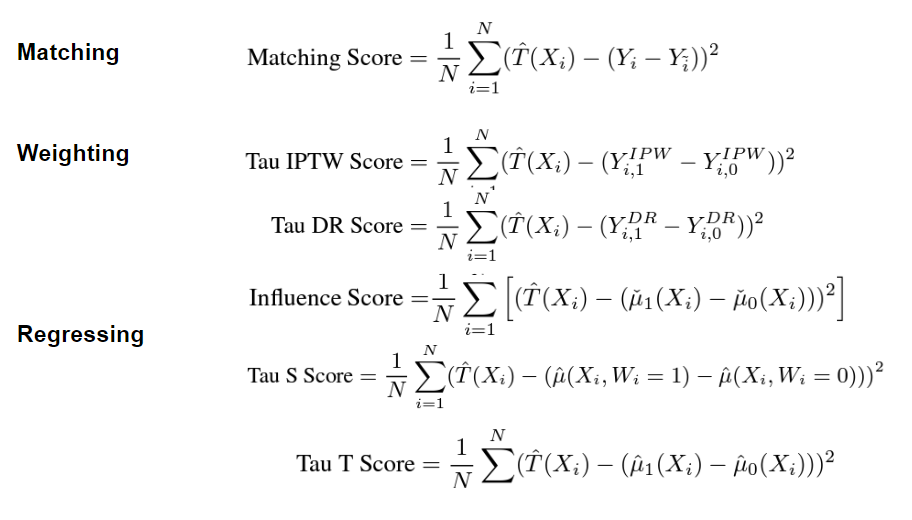

In [12]:
def print_table(header, data):
    table_width = 79
    header_line = f'| {header.center(table_width - 4)} |'
    separator_line = f'+{"-" * (table_width - 2)}+'

    print(separator_line)
    print(header_line)
    print(separator_line)

    for row in data:
        row_line = f'| {row[0].ljust(30)} | {row[1].ljust(15)} | {str(row[2]).ljust(24)} |'
        print(row_line)

    print(separator_line)

def evaluate(estimator_name, metrics_set):
    print(f'{" Evaluation ":-^79}')
    results_in = {}
    results_out = {}
    if dataset_name == "Jobs":
        ate_in_gt, ate_out_gt = helper.load_Jobs_ground_truth(
            datasets_folder, dataset_name, details=False
        )
        mu0_in, mu1_in, mu0_out, mu1_out = None, None, None, None
        x_all, t_all, yf_all = helper.load_Jobs_observational(
            datasets_folder, dataset_name, details=False
        )
        x_test_all, t_test_all, yf_test_all = helper.load_Jobs_out_of_sample(
            datasets_folder, dataset_name, details=False
        )
    elif dataset_name == "TWINS":
        mu0_in, mu1_in, mu0_out, mu1_out = helper.load_TWINS_ground_truth(
            datasets_folder, dataset_name, details=False
        )
        ate_in_gt = np.mean(mu1_in - mu0_in)
        ate_out_gt = np.mean(mu1_out - mu0_out)
        x_all, t_all, yf_all = helper.load_TWINS_observational(
            datasets_folder, dataset_name, details=False
        )
        x_test_all, t_test_all, yf_test_all = helper.load_TWINS_out_of_sample(
            datasets_folder, dataset_name, details=False
        )
        mu0_in, mu1_in, mu0_out, mu1_out = helper.load_TWINS_ground_truth(
            datasets_folder, dataset_name, details=False
        )

    # process in sample data
    data_size_in = x_all.shape[0]
    num_realizations_in = 1
    if len(x_all.shape) == 3:
        num_realizations_in = x_all.shape[2]
        new_x_all = np.zeros((data_size_in * num_realizations_in, x_all.shape[1]))
        for i in range(num_realizations_in):
            new_x_all[i * data_size_in : (i + 1) * data_size_in, :] = x_all[:, :, i]
        x_all = new_x_all

    
    # squeeze all eval data
    x_all = np.reshape(x_all, (data_size_in*num_realizations_in, x_all.shape[1]))
    t_all = np.reshape(t_all, (data_size_in * num_realizations_in), order='F')
    yf_all = np.reshape(yf_all, (data_size_in * num_realizations_in), order='F')

    indices_all = np.arange(x_all.shape[0])

    x_train, x_eval_orig, t_train, t_eval_orig, yf_train, yf_eval_orig, indices_train, indices_eval = train_test_split(
        x_all, t_all, yf_all, indices_all, test_size=0.2, random_state=seed
        )
    
    # process out of sample data
    data_size_out = x_test_all.shape[0]
    num_realizations_out = 1
    if len(x_test_all.shape) == 3:
        num_realizations_out = x_test_all.shape[2]
        new_x_test_all = np.zeros((data_size_out * num_realizations_out, x_test_all.shape[1]))
        for i in range(num_realizations_out):
            new_x_test_all[i * data_size_out : (i + 1) * data_size_out, :] = x_test_all[:, :, i]
        x_test_all = new_x_test_all
    
    # squeeze all test data
    x_test_all = np.reshape(x_test_all, (data_size_out*num_realizations_out, x_test_all.shape[1]))
    t_test_all = np.reshape(t_test_all, (data_size_out * num_realizations_out), order='F')
    yf_test_all = np.reshape(yf_test_all, (data_size_out * num_realizations_out), order='F')

    #Computing relevant evaluation metric for ensemble for in sample data
    nuisance_stats_dir= results_folder + '//..//models//' + dataset_name + '//'
    # Nuisance Models
    prop_prob_orig, prop_score_orig = get_nuisance_propensity_pred(x_eval_orig, t_eval_orig, save_dir=nuisance_stats_dir)
    outcome_s_pred = get_nuisance_outome_s_pred(x_eval_orig, t_eval_orig, save_dir=nuisance_stats_dir)
    outcome_t_pred = get_nuisance_outcome_t_pred(x_eval_orig, t_eval_orig, save_dir=nuisance_stats_dir)
    outcome_r_pred = get_nuisance_outcome_r_pred(x_eval_orig, save_dir=nuisance_stats_dir)

    outcome_s_pred_orig = np.array(outcome_s_pred)
    outcome_t_pred_orig = np.array(outcome_t_pred)
    outcome_r_pred_orig = np.array(outcome_r_pred)

    #Computing relevant evaluation metric for ensemble for out of sample data
    # Nuisance Models
    prop_prob_test, prop_score_test = get_nuisance_propensity_pred(x_test_all, t_test_all, save_dir=nuisance_stats_dir)
    outcome_s_pred = get_nuisance_outome_s_pred(x_test_all, t_test_all, save_dir=nuisance_stats_dir)
    outcome_t_pred = get_nuisance_outcome_t_pred(x_test_all, t_test_all, save_dir=nuisance_stats_dir)
    outcome_r_pred = get_nuisance_outcome_r_pred(x_test_all, save_dir=nuisance_stats_dir)

    outcome_s_pred_test = np.array(outcome_s_pred)
    outcome_t_pred_test = np.array(outcome_t_pred)
    outcome_r_pred_test = np.array(outcome_r_pred)

    estimation_result_folder = os.path.join(
        results_folder, dataset_name, estimator_name
    )
    (
        y0_in,
        y1_in,
        ate_in,
        y0_out,
        y1_out,
        ate_out,
    ) = helper.load_in_and_out_results(estimation_result_folder)
    
    if dataset_name == "TWINS":
        y0_in = y0_in.reshape((-1, 1))
        y1_in = y1_in.reshape((-1, 1))
        y0_out = y0_out.reshape((-1, 1))
        y1_out = y1_out.reshape((-1, 1))
        ate_in = ate_in.reshape((-1, 1))
        ate_out = ate_out.reshape((-1, 1))
            
    results_in[estimator_name] = {}
    results_out[estimator_name] = {}

    # process in sample data
    ite_estimate_in = y1_in.reshape((-1, 1), order='F') - y0_in.reshape((-1, 1), order='F')
    ite_estimate_eval = ite_estimate_in[indices_eval]

    # get indices of non nan values
    non_nan = ~np.isnan(ite_estimate_eval)
    non_nan_inds = np.where(non_nan)[0]
    ite_estimate_eval = ite_estimate_eval[non_nan_inds]
    x_eval = np.take(x_eval_orig, non_nan_inds, axis=0)
    t_eval = t_eval_orig[non_nan.squeeze()]
    yf_eval = yf_eval_orig[non_nan.squeeze()]
    
    prop_score = prop_score_orig[non_nan.squeeze()]
    outcome_s_pred = np.transpose(np.transpose(outcome_s_pred_orig)[non_nan.squeeze()])
    outcome_t_pred = np.transpose(np.transpose(outcome_t_pred_orig)[non_nan.squeeze()])
    outcome_r_pred = outcome_r_pred_orig[non_nan.squeeze()]
    prop_prob = prop_prob_orig[non_nan.squeeze()]

    # process out of sample data
    ite_estimate_out = y1_out.reshape((-1, 1), order='F') - y0_out.reshape((-1, 1), order='F')
    ite_estimate_eval_out = ite_estimate_out

    # get indices of non nan values
    non_nan = ~np.isnan(ite_estimate_eval_out)
    non_nan_inds = np.where(non_nan)[0]
    ite_estimate_eval_out = ite_estimate_eval_out[non_nan_inds]
    x_eval_out = np.take(x_test_all, non_nan_inds, axis=0)
    t_eval_out = t_test_all[non_nan.squeeze()]
    yf_eval_out = yf_test_all[non_nan.squeeze()]

    prop_score_out = prop_score_test[non_nan.squeeze()]
    outcome_s_pred_out = np.transpose(np.transpose(outcome_s_pred_test)[non_nan.squeeze()])
    outcome_t_pred_out = np.transpose(np.transpose(outcome_t_pred_test)[non_nan.squeeze()])
    outcome_r_pred_out = outcome_r_pred_test[non_nan.squeeze()]
    prop_prob_out = prop_prob_test[non_nan.squeeze()]

    for metric in metrics_set:
        metric_in = None
        if metric in ["MAE", "PEHE"]:
            metric_in = metrics.calculate_metrics(
                y0_in, y1_in, ate_in, mu0_in, mu1_in, ate_in_gt, metric=metric
            )
            metric_out = metrics.calculate_metrics(
                y0_out, y1_out, ate_out, mu0_out, mu1_out, ate_out_gt, metric=metric
            )
        elif metric == "value_score":
            metric_in = metrics.calculate_value_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, dataset_name=dataset_name, prop_score=prop_score
            )
            metric_out = metrics.calculate_value_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, dataset_name=dataset_name, prop_score=prop_score_out
            )
        elif metric == "value_dr_score":
            metric_in = metrics.calculate_value_dr_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_t_pred, dataset_name=dataset_name, prop_score=prop_score
            )
            metric_out = metrics.calculate_value_dr_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_t_pred_out, dataset_name=dataset_name, prop_score=prop_score_out
            )
        elif metric == "value_dr_clip_prop_score":
            metric_in = metrics.calculate_value_dr_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_t_pred, dataset_name=dataset_name, prop_score=prop_score, min_propensity=0.1
            )
            metric_out = metrics.calculate_value_dr_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_t_pred_out, dataset_name=dataset_name, prop_score=prop_score_out, min_propensity=0.1
            )
        elif metric == "tau_match_score":
            metric_in = metrics.calculate_tau_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval
            )
            metric_out = metrics.calculate_tau_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out
            )
        elif metric == "tau_iptw_score":
            metric_in = metrics.calculate_tau_iptw_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, prop_score=prop_score
            )
            metric_out = metrics.calculate_tau_iptw_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, prop_score=prop_score_out
            )
        elif metric == "tau_iptw_clip_prop_score":
            metric_in = metrics.calculate_tau_iptw_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, prop_score=prop_score, min_propensity=0.1
            )
            metric_out = metrics.calculate_tau_iptw_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, prop_score=prop_score_out, min_propensity=0.1
            )
        elif metric == "tau_dr_score":
            metric_in = metrics.calculate_tau_dr_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_t_pred, prop_score=prop_score
            )
            metric_out = metrics.calculate_tau_dr_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_t_pred_out, prop_score=prop_score_out
            )
        elif metric == "tau_dr_clip_prop_score":
            metric_in = metrics.calculate_tau_dr_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_t_pred, prop_score=prop_score, min_propensity=0.1
            )
            metric_out = metrics.calculate_tau_dr_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_t_pred_out, prop_score=prop_score_out, min_propensity=0.1
            )
        elif metric == "tau_s_score":
            metric_in = metrics.calculate_tau_s_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_s_pred
            )
            metric_out = metrics.calculate_tau_s_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_s_pred_out
            )
        elif metric == "tau_t_score":
            metric_in = metrics.calculate_tau_t_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_t_pred
            )
            metric_out = metrics.calculate_tau_t_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_t_pred_out
            )
        elif metric == "influence_score":
            metric_in = metrics.calculate_influence_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_t_pred, prop_prob=prop_prob
            )
            metric_out = metrics.calculate_influence_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_t_pred_out, prop_prob=prop_prob_out
            )
        elif metric == "influence_clip_prop_score":
            metric_in = metrics.calculate_influence_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_t_pred, prop_prob=prop_prob, min_propensity=0.1
            )
            metric_out = metrics.calculate_influence_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_t_pred_out, prop_prob=prop_prob_out, min_propensity=0.1
            )
        elif metric == "r_score":
            metric_in = metrics.calculate_r_risk(
                ite_estimate_eval, x_eval, t_eval, yf_eval, outcome_pred=outcome_r_pred, treatment_prob=prop_prob[:, 1]
            )
            metric_out = metrics.calculate_r_risk(
                ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, outcome_pred=outcome_r_pred_out, treatment_prob=prop_prob_out[:, 1]
            )

        if metric_in is None:
            results_in[estimator_name][metric] = {"mean": None}
        else:
            results_in[estimator_name][metric] = {
                "mean": np.mean(metric_in, where=(metric_in != 0)),
            }
        if metric_out is None:
            results_out[estimator_name][metric] = {"mean": None}
        else:
            results_out[estimator_name][metric] = {
                "mean": np.mean(metric_out, where=(metric_out != 0)),
            }
    
    # In-sample results
    header_in = f' In-sample results '
    data_in = [[metric, estimator_name, results_in[estimator_name][metric]["mean"]] for metric in metrics_set]

    # Out-of-sample results
    header_out = f' Out-of-sample results '
    data_out = [[metric, estimator_name, results_out[estimator_name][metric]["mean"]] for metric in metrics_set]

    print_table(header_in, data_in)
    print_table(header_out, data_out)

Select which estimator you want to evaluate below.

In [15]:
estimator = "NN1" #@param estimator_set = ["OLS1", "OLS2", "NN1", "NN2", "RF1", "RF2", "Dragonnet", "TARNet"]

Select the metric (or "ALL") from below to retreive the value. Ensure you've selected an estimator at the previous step.

In [16]:
metric = "ALL" #@param [ "MAE", "PEHE", "value_score", "value_dr_score", "value_dr_clip_prop_score", "tau_t_score", "tau_s_score", "tau_match_score", "tau_iptw_score", "tau_iptw_clip_prop_score", "tau_dr_score", "tau_dr_clip_prop_score", "influence_score", "influence_clip_prop_score", "r_score", "ALL"]
if metric == "ALL":
  metric_set = [ "MAE", "PEHE", "value_score", "value_dr_score", "value_dr_clip_prop_score", "tau_t_score", "tau_s_score", "tau_match_score", "tau_iptw_score", "tau_iptw_clip_prop_score", "tau_dr_score", "tau_dr_clip_prop_score", "influence_score", "influence_clip_prop_score", "r_score"]
else:
  metric_set = [metric]

evaluate(estimator, metric_set)

--------------------------------- Evaluation ----------------------------------
+-----------------------------------------------------------------------------+
|                              In-sample results                              |
+-----------------------------------------------------------------------------+
| MAE                            | NN1             | 0.033310226133823354     |
| PEHE                           | NN1             | 0.033310226133823354     |
| value_score                    | NN1             | -0.42828345358835657     |
| value_dr_score                 | NN1             | -0.0032980584014291664   |
| value_dr_clip_prop_score       | NN1             | -0.004038355332557093    |
| tau_t_score                    | NN1             | 0.1440715152240839       |
| tau_s_score                    | NN1             | 0.054470807              |
| tau_match_score                | NN1             | 0.18029569767738704      |
| tau_iptw_score                 | NN1  

# References
[1] J. L. Hill, “Bayesian nonparametric modeling for causal inference,” Journal
of Computational  and Graphical Statistics, vol. 20, no. 1, pp. 217–240, 2011.
[Online]. Available: https://doi.org/10.1198/jcgs.2010.08162

[2] R. J. LaLonde, “Evaluating the econometric evaluations of training programs
with experimental data,” The American Economic Review, vol. 76, no. 4, pp.
604–620, 1986. [Online]. Available: http://www.jstor.org/stable/1806062

[3] U. Shalit, F. D. Johansson, and D. Sontag, “Estimating individual treatment
effect: generalization bounds and algorithms,” in Proceedings of the 34th
International Conference on Machine Learning, ser. Proceedings of Machine
Learning Research, D. Precup and Y. W. Teh, Eds., vol. 70. PMLR, 06–11 Aug 2017
, pp. 3076–3085. [Online].
Available: https://proceedings.mlr.press/v70/shalit17a.html

[4] Christos Louizos, Uri Shalit, Joris Mooij, David Sontag, Richard Zemel, and Max Welling. Causal effect inference with deep latent-variable models. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17), 6449–6459, 2017.

[5] D. Almond, K. Y. Chay, and D. S. Lee. The costs of low birth weight.The Quarterly Journal of Economics,120(3):1031–1083, 2005.

[6] D. Mahajan, I. Mitliagkas, B. Neal, and V. Syrgkanis, ‘Empirical Analysis of Model Selection for Heterogenous Causal Effect Estimation’, arXiv [cs.LG]. 2022.
